Distance MAE: 3.85


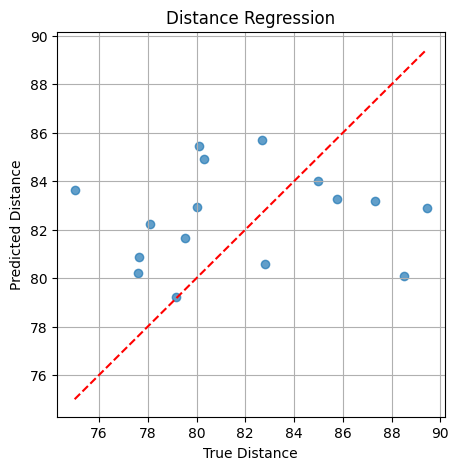

Error Classification Report (Any Error):
              precision    recall  f1-score   support

    No Error       0.00      0.00      0.00         4
   Any Error       0.75      1.00      0.86        12

    accuracy                           0.75        16
   macro avg       0.38      0.50      0.43        16
weighted avg       0.56      0.75      0.64        16



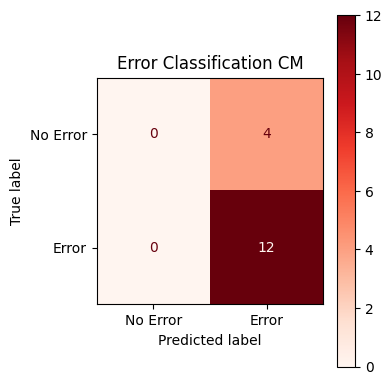

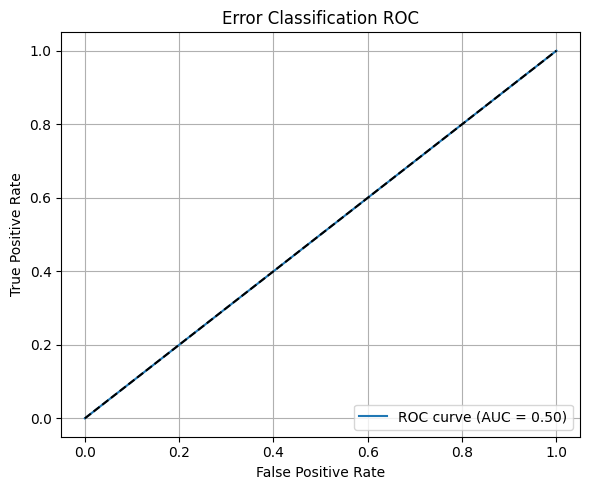

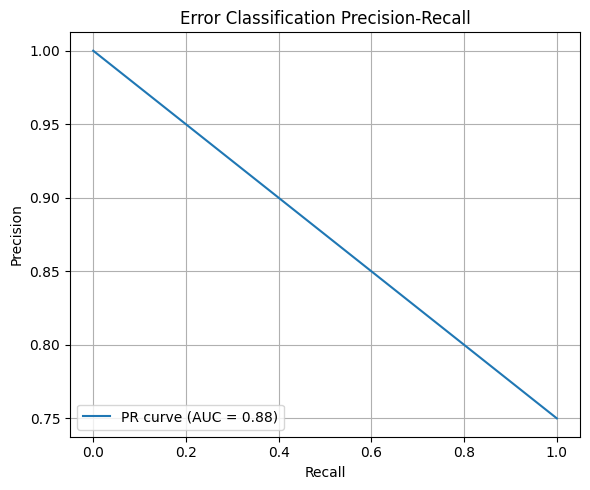

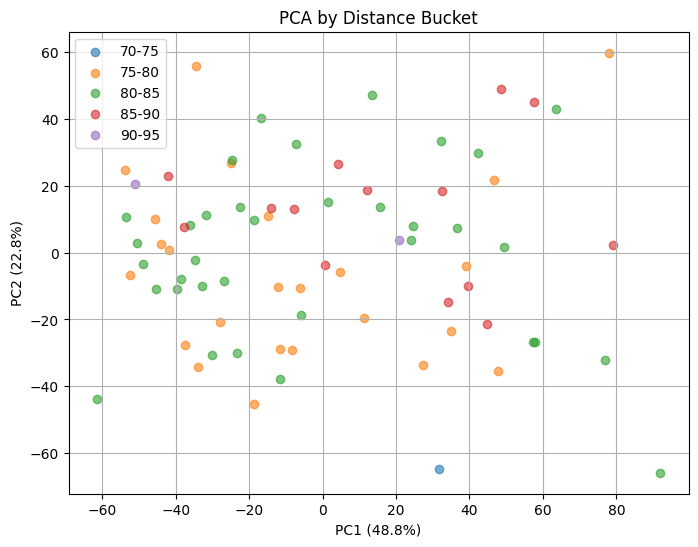

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib
import mediapipe as mp
from math import acos, degrees

# --- CONFIGURATION ---
SMOOTH_DIR    = 'smoothed_landmarks'
FRAMES_BEFORE = 15
FRAMES_AFTER  = 7
WINDOW_FRAMES = FRAMES_BEFORE + 1 + FRAMES_AFTER

# Distance buckets and labels
dist_bin_edges  = [0, 70, 75, 80, 85, 90, 95, np.inf]
dist_bin_labels = ['<70','70-75','75-80','80-85','85-90','90-95','95+']

# --- PLACEHOLDER DICTIONARIES ---
DISTANCES = {}
THROW_FRAMES = {}

if not THROW_FRAMES or not DISTANCES:
    raise ValueError("Populate THROW_FRAMES and DISTANCES before running.")

# --- UTILITIES ---
mp_pose = mp.solutions.pose

def angle(A, B, C):
    BA, BC = A - B, C - B
    cosv = np.dot(BA, BC) / (np.linalg.norm(BA) * np.linalg.norm(BC) + 1e-6)
    return degrees(acos(np.clip(cosv, -1, 1)))

def smooth(seq, pad=2, window=5):
    padded = np.pad(seq, ((pad,pad),(0,0),(0,0)), mode='edge')
    out = np.empty_like(seq)
    for i in range(len(seq)):
        out[i] = padded[i:i+window].mean(axis=0)
    return out

# Error metrics
def score_errors(sm):
    xyz = sm[:,:,:3]
    feats = []
    # low_elbow_depth
    d = xyz[:,mp_pose.PoseLandmark.LEFT_SHOULDER.value,1] - xyz[:,mp_pose.PoseLandmark.LEFT_ELBOW.value,1]
    feats += [d.mean(), d.max()]
    # torso_openness
    o = np.abs(xyz[:,mp_pose.PoseLandmark.RIGHT_SHOULDER.value,0] - xyz[:,mp_pose.PoseLandmark.LEFT_SHOULDER.value,0])
    feats += [o.mean(), o.max()]
    # lean_back
    v = xyz[:,mp_pose.PoseLandmark.LEFT_HIP.value] - xyz[:,mp_pose.PoseLandmark.LEFT_SHOULDER.value]
    cosv = np.einsum('ij,j->i', v, [0,1,0])/(np.linalg.norm(v,axis=1)+1e-6)
    lean = np.degrees(np.arccos(np.clip(cosv,-1,1))) - 90
    feats += [lean.mean(), lean.max()]
    # block_offset
    b = np.abs(xyz[:,mp_pose.PoseLandmark.LEFT_ANKLE.value,0] - xyz[:,mp_pose.PoseLandmark.LEFT_KNEE.value,0])
    feats += [b.mean(), b.max()]
    return np.array(feats, dtype=np.float32)

# Feature summarization
def summarize_feats(sm):
    prev = sm[0,mp_pose.PoseLandmark.LEFT_WRIST.value,:3]
    records=[]
    for frm in sm:
        lm=frm[:,:3]
        e=angle(lm[mp_pose.PoseLandmark.LEFT_WRIST.value],lm[mp_pose.PoseLandmark.LEFT_ELBOW.value],lm[mp_pose.PoseLandmark.LEFT_SHOULDER.value])
        h=angle(lm[mp_pose.PoseLandmark.LEFT_HIP.value],lm[mp_pose.PoseLandmark.LEFT_KNEE.value],lm[mp_pose.PoseLandmark.LEFT_ANKLE.value])
        v=np.linalg.norm(lm[mp_pose.PoseLandmark.LEFT_WRIST.value]-prev)
        records.append([e,h,v]); prev=lm[mp_pose.PoseLandmark.LEFT_WRIST.value]
    arr=np.array(records)
    stats=[]
    for i in range(arr.shape[1]): c=arr[:,i]; stats += [c.mean(),c.std(),c.max(),c.min(),c[-1]-c[0]]
    return np.array(stats, dtype=np.float32)

# Load clip landmarks
def load_clip(cid): return np.load(os.path.join(SMOOTH_DIR, f'clip_{cid}.npy'))

# --- COLLECT DATA ---
X=[]; y_dist=[]
for cid,tf in THROW_FRAMES.items():
    clip=load_clip(cid)
    seg=clip[max(0,tf-FRAMES_BEFORE):tf+FRAMES_AFTER+1]
    if len(seg)<WINDOW_FRAMES:
        seg=np.pad(seg,((0,WINDOW_FRAMES-len(seg)),(0,0),(0,0)),mode='edge')
    sm=smooth(seg)
    err=score_errors(sm)
    summ=summarize_feats(sm)
    X.append(np.concatenate([err,summ])); y_dist.append(DISTANCES[cid])
X_all=np.vstack(X); y_dist=np.array(y_dist)

# --- DISTANCE REGRESSION ---
Xr_tr,Xr_v,yd_tr,yd_v=train_test_split(X_all,y_dist,test_size=0.2,random_state=42)
reg=GradientBoostingRegressor(learning_rate=0.05,n_estimators=100,random_state=42)
reg.fit(Xr_tr, yd_tr)
ypred_d = reg.predict(Xr_v)
print(f"Distance MAE: {mean_absolute_error(yd_v, ypred_d):.2f}")
plt.figure(figsize=(5,5))
plt.scatter(yd_v, ypred_d, alpha=0.7)
plt.plot([yd_v.min(),yd_v.max()],[yd_v.min(),yd_v.max()], 'r--')
plt.xlabel('True Distance'); plt.ylabel('Predicted Distance')
plt.title('Distance Regression')
plt.grid(True); plt.show()
joblib.dump(reg,'distance_regressor_gbr.pkl')

# --- ERROR CLASSIFICATION ---
import warnings
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.exceptions import UndefinedMetricWarning

# Suppress undefined metric warnings for precision
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Generate binary error labels (any error across metrics)
error_metrics = np.array([
    score_errors(
        smooth(
            load_clip(cid)[max(0, tf-FRAMES_BEFORE):tf+FRAMES_AFTER+1]
        )
    ) for cid, tf in THROW_FRAMES.items()
])
thresholds = np.percentile(X_all[:,:8], 75, axis=0)
y_true_err = (error_metrics > thresholds).any(axis=1).astype(int)

# Split for binary classification
e_X_tr, e_X_v, e_y_tr, e_y_v = train_test_split(X_all, y_true_err, test_size=0.2, random_state=42)
clf = MLPClassifier(hidden_layer_sizes=(64,32), max_iter=200, random_state=42)
clf.fit(e_X_tr, e_y_tr)
y_pred_err = clf.predict(e_X_v)
y_proba = clf.predict_proba(e_X_v)[:,1]

# Classification report
print("Error Classification Report (Any Error):")
print(classification_report(e_y_v, y_pred_err, target_names=['No Error','Any Error'], zero_division=0))

# Confusion matrix heatmap
cm = confusion_matrix(e_y_v, y_pred_err)
plt.figure(figsize=(4,4))
ConfusionMatrixDisplay(cm, display_labels=['No Error','Error']).plot(cmap='Reds', ax=plt.gca())
plt.title('Error Classification CM')
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(e_y_v, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Error Classification ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(e_y_v, y_proba)
pr_auc = auc(recall, precision)
plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Error Classification Precision-Recall')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()

joblib.dump(clf, 'error_classifier_mlp.pkl')

# --- PCA by DISTANCE BUCKET ---
b_ids = np.digitize(y_dist, dist_bin_edges)-1
labels = np.array(dist_bin_labels)[b_ids]
pca = PCA(n_components=2)
pcs = pca.fit_transform(X_all)
plt.figure(figsize=(8,6))
for l in np.unique(labels): m = labels==l; plt.scatter(pcs[m,0],pcs[m,1],label=l,alpha=0.6)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title('PCA by Distance Bucket'); plt.legend(); plt.grid(True); plt.show()


Summaries saved to unseen_clips_summary.csv and summary_plots.png


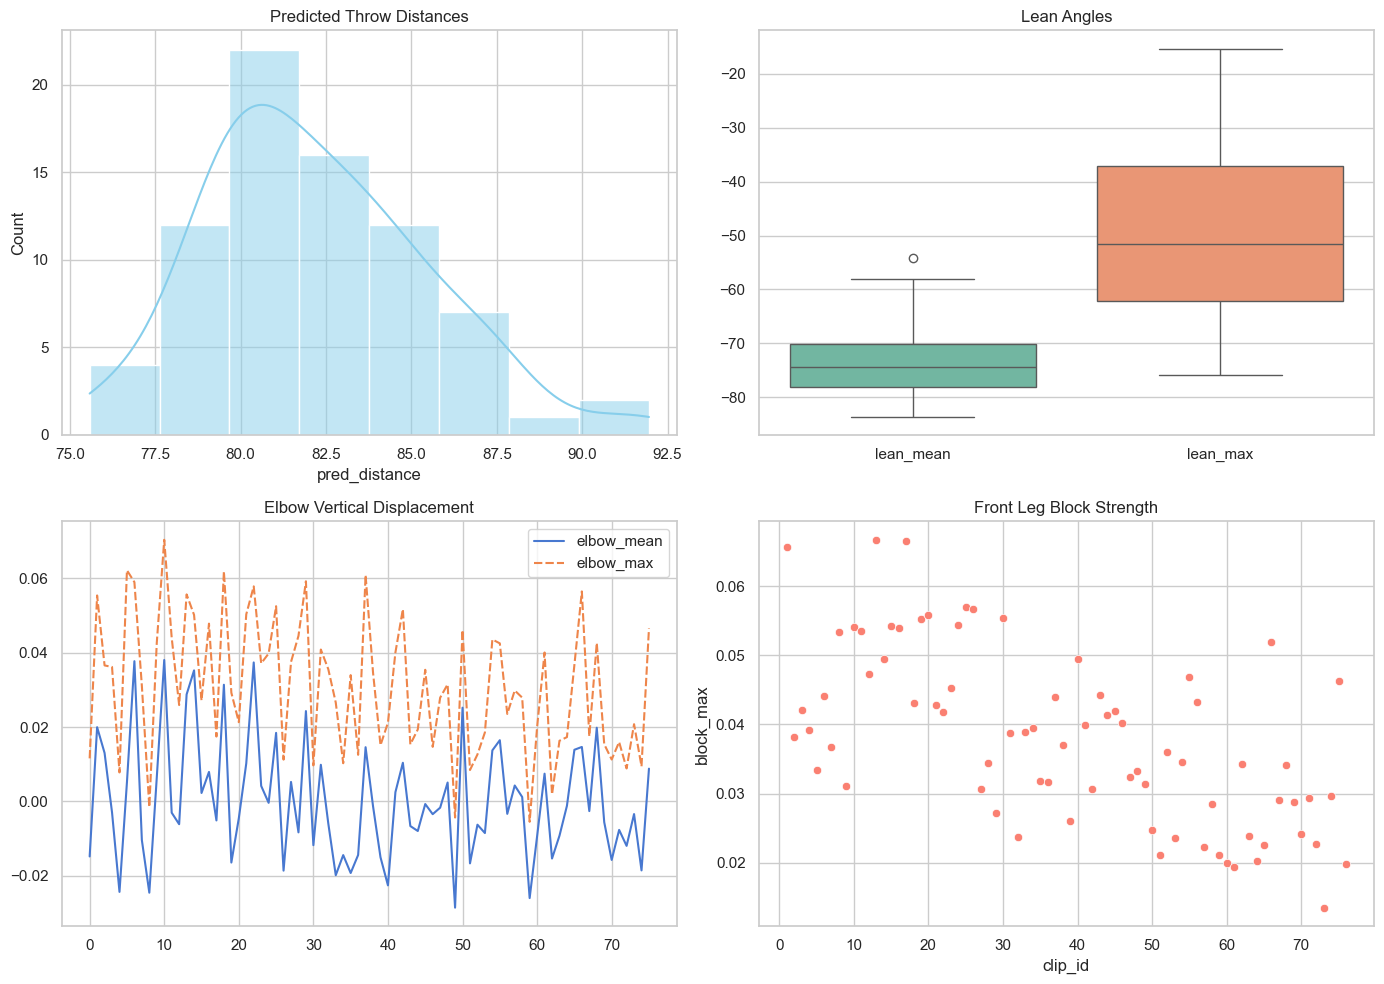

In [24]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import mediapipe as mp
from math import acos, degrees
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# === CONFIGURATION ===
SMOOTH_DIR        = 'smoothed_landmarks'
WINDOW_BEFORE     = 15
WINDOW_AFTER      = 7
WINDOW            = WINDOW_BEFORE + 1 + WINDOW_AFTER
DIST_MODEL_PATH   =  'distance_regressor_gbr.pkl'
ERR_MODEL_PATH    =  'error_classifier_mlp.pkl'
TF_MODEL_PATH     =  'throw_frame_detector.pkl'

# === UTILITIES ===
mp_pose = mp.solutions.pose

def angle(A, B, C):
    BA, BC = A - B, C - B
    cosv = np.dot(BA, BC) / (np.linalg.norm(BA)*np.linalg.norm(BC) + 1e-6)
    return degrees(acos(np.clip(cosv, -1, 1)))

def smooth(seq, pad=2, window=5):
    padded = np.pad(seq, ((pad,pad),(0,0),(0,0)), mode='edge')
    out = np.empty_like(seq)
    for i in range(len(seq)):
        out[i] = padded[i:i+window].mean(axis=0)
    return out

# 1) throw-frame features
def extract_tf_feature(window_frames):
    mid = WINDOW_BEFORE
    curr = window_frames[mid].flatten()
    prev = window_frames[mid-1].flatten()
    nxt  = window_frames[mid+1].flatten()
    velocity     = nxt - prev
    acceleration = nxt - 2*curr + prev
    return np.concatenate([curr, velocity, acceleration])

# 2) error metrics
def score_errors_segment(sm):
    xyz = sm[..., :3]
    feats = []
    d = xyz[:,mp_pose.PoseLandmark.LEFT_SHOULDER.value,1] - xyz[:,mp_pose.PoseLandmark.LEFT_ELBOW.value,1]
    feats += [d.mean(), d.max()]
    o = np.abs(xyz[:,mp_pose.PoseLandmark.RIGHT_SHOULDER.value,0] - xyz[:,mp_pose.PoseLandmark.LEFT_SHOULDER.value,0])
    feats += [o.mean(), o.max()]
    vec = xyz[:,mp_pose.PoseLandmark.LEFT_HIP.value] - xyz[:,mp_pose.PoseLandmark.LEFT_SHOULDER.value]
    vert = np.array([0,1,0])
    cosv = np.einsum('ij,j->i', vec, vert)/(np.linalg.norm(vec,axis=1)+1e-6)
    lean = np.degrees(np.arccos(np.clip(cosv,-1,1))) - 90
    feats += [lean.mean(), lean.max()]
    b = np.abs(xyz[:,mp_pose.PoseLandmark.LEFT_ANKLE.value,0] - xyz[:,mp_pose.PoseLandmark.LEFT_KNEE.value,0])
    feats += [b.mean(), b.max()]
    return np.array(feats, dtype=np.float32)

# 3) kinematic summarization
def summarize_feats_segment(sm):
    prev = sm[0, mp_pose.PoseLandmark.LEFT_WRIST.value, :3]
    arr = []
    for frm in sm:
        lm = frm[..., :3]
        e = angle(lm[mp_pose.PoseLandmark.LEFT_WRIST.value], lm[mp_pose.PoseLandmark.LEFT_ELBOW.value], lm[mp_pose.PoseLandmark.LEFT_SHOULDER.value])
        h = angle(lm[mp_pose.PoseLandmark.LEFT_HIP.value], lm[mp_pose.PoseLandmark.LEFT_KNEE.value], lm[mp_pose.PoseLandmark.LEFT_ANKLE.value])
        v = np.linalg.norm(lm[mp_pose.PoseLandmark.LEFT_WRIST.value] - prev)
        arr.append([e,h,v]); prev = lm[mp_pose.PoseLandmark.LEFT_WRIST.value]
    arr = np.array(arr)
    stats = []
    for i in range(arr.shape[1]): c=arr[:,i]; stats += [c.mean(),c.std(),c.max(),c.min(),c[-1]-c[0]]
    return np.array(stats, dtype=np.float32)

# load clip
def load_clip_array(fname): return np.load(os.path.join(SMOOTH_DIR, fname))

# throw-frame prediction
def predict_throw_frame(clip_arr, clf_tf):
    probs=[]
    for i in range(WINDOW_BEFORE, len(clip_arr)-WINDOW_AFTER):
        win = clip_arr[i-WINDOW_BEFORE:i+WINDOW_AFTER+1]
        feat = extract_tf_feature(win)
        p = clf_tf.predict_proba(feat.reshape(1,-1))[0][1]
        probs.append((i,p))
    return max(probs, key=lambda x: x[1])[0] if probs else len(clip_arr)//2

# full feature vector
def extract_segment_features(clip_arr, tf_pred):
    seg = clip_arr[max(0,tf_pred-WINDOW_BEFORE):tf_pred+WINDOW_AFTER+1]
    if seg.shape[0]<WINDOW: seg=np.pad(seg,((0,WINDOW-seg.shape[0]),(0,0),(0,0)),mode='edge')
    sm = smooth(seg)
    return np.concatenate([score_errors_segment(sm), summarize_feats_segment(sm)])

# Generate player-friendly summary
def generate_player_summary(row):
    feedback = []
    if row['pred_distance'] > 70:
        feedback.append("💪 Excellent throw distance! Keep building strength.")
    elif row['pred_distance'] > 50:
        feedback.append("👍 Good distance. Focus on power for improvement.")
    else:
        feedback.append("📈 Work on speed and technique to increase distance.")

    if row['lean_mean'] < 10:
        feedback.append("⚠️ Increase your torso lean to generate more forward momentum.")
    else:
        feedback.append("✅ Great torso lean, helps with power transfer.")

    if row['block_max'] < 0.05:
        feedback.append("🦵 Improve your front leg block to enhance energy transfer during the throw.")

    if row['error_flag']:
        feedback.append("❌ Form inconsistencies detected. Consider reviewing your posture.")

    return " ".join(feedback)

# === LOAD MODELS ===
reg     = joblib.load(DIST_MODEL_PATH)
clf_err = joblib.load(ERR_MODEL_PATH)
clf_tf  = joblib.load(TF_MODEL_PATH)

# === PROCESS CLIPS ===
records=[]
for fname in sorted(os.listdir(SMOOTH_DIR)):
    if not fname.endswith('.npy'): continue
    cid= int(fname.replace('clip_','').replace('.npy',''))
    arr= load_clip_array(fname)
    tf_pred= predict_throw_frame(arr, clf_tf)
    feats= extract_segment_features(arr, tf_pred)
    d_pred= reg.predict(feats.reshape(1,-1))[0]
    err_flag= bool(clf_err.predict(feats.reshape(1,-1))[0])
    # Build metrics dict
    metrics = {"clip_id": cid, "throw_frame": tf_pred, "pred_distance": d_pred, "error_flag": float(err_flag)}
    # Add error and kinematic metrics
    err_feats = score_errors_segment(smooth(arr[max(0,tf_pred-WINDOW_BEFORE):tf_pred+WINDOW_AFTER+1]))
    kin_feats = summarize_feats_segment(smooth(arr[max(0,tf_pred-WINDOW_BEFORE):tf_pred+WINDOW_AFTER+1]))
    keys = ["elbow_mean","elbow_max","torso_mean","torso_max","lean_mean","lean_max","block_mean","block_max"]
    for i,k in enumerate(keys): metrics[k]= err_feats[i]
    kin_keys=[f"kin_{i}" for i in range(len(kin_feats))]
    for i,k in enumerate(kin_keys): metrics[k]= kin_feats[i]
    records.append(metrics)

# === OUTPUT ===
results_df = pd.DataFrame(records).sort_values('clip_id')
results_df["player_feedback"] = results_df.apply(generate_player_summary, axis=1)
results_df.to_csv('unseen_clips_summary.csv', index=False)

# === PLOT ===
sns.set(style="whitegrid")
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Distance
sns.histplot(results_df['pred_distance'], kde=True, ax=axs[0,0], color="skyblue")
axs[0,0].set_title("Predicted Throw Distances")

# Lean
sns.boxplot(data=results_df[['lean_mean', 'lean_max']], ax=axs[0,1], palette="Set2")
axs[0,1].set_title("Lean Angles")

# Elbow movement
sns.lineplot(data=results_df[['elbow_mean','elbow_max']], ax=axs[1,0], palette="muted")
axs[1,0].set_title("Elbow Vertical Displacement")

# Block stability
sns.scatterplot(x='clip_id', y='block_max', data=results_df, ax=axs[1,1], color="salmon")
axs[1,1].set_title("Front Leg Block Strength")

plt.tight_layout()
plt.savefig("summary_plots.png")
print("Summaries saved to unseen_clips_summary.csv and summary_plots.png")
